# Recreational Areas In Los Angeles
#### Kayla Chaoui z5214021

Data provided by the California Department of Parks and Recreation and the U.S. 2010 Census.

The dataset published by the California Department of Parks and Recreation lists the recreational facilities in the LA city area including details of their type, locations and council association. This analysis incorporated the 2010 Census data for LA which was comprised of each zip code's population, median age and households.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import os
import geopandas as gp
import shapely
import fiona
import squarify

In [110]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
saved_style_state = matplotlib.rcParams.copy() 
plt.rc('font',family='avenir')
plt.rc('figure', titlesize=25)

plt.style.use('fivethirtyeight')

In [3]:
#Getting data from file path
def getdata(filepath):
    if os.path.isfile(filepath):

        print("loading from file")
        print("done")
    else:
        print("Put ur file there")
    return(pd.read_csv(filepath, low_memory=False))

In [4]:
dfrec_data= getdata("park_info.csv")
#dfrec_data=dfrec_data.drop(dfrec_data.index[101]) #removes the 92325 zip code, it is not in the LA city region so it has no census data
print(dfrec_data[dfrec_data['Zip']== 92325].index.values)
dfrec_data=dfrec_data.drop(dfrec_data.index[855])


dfcensus = getdata("census.csv")
dfcensus_data=dfcensus.rename(columns=({'Zip Code':'Zip','Total Population':'Population','Median Age':'MedianAge','Total Males':'Males','Total Females':'Females','Total Households':'Households','Average Household Size':'AvgHouseholdSize'}))


loading from file
done
[855]
loading from file
done


In [5]:
dfrec_data.GeoLong=dfrec_data.GeoLong.apply(lambda x:x if x < -118 else None) #this cleaned the data, there were two outliers that affected the mapping and graphing of the data
#dfrec_data.GeoLong.hist()

In [233]:
counts=dfrec_data["Zip"].value_counts()
reccounts = pd.DataFrame(counts)
reccounts["new_column"] = reccounts.index
reccounts.reset_index(drop=True, inplace=True)
reccounts=reccounts.rename(columns=({'Zip':'Total_Count','new_column': 'Zip'}))
columns_titles = ["Zip","Total_Count"]
reccounts=reccounts.reindex(columns=columns_titles)

zipinfo=pd.DataFrame(dfcensus_data)

dfmerged_data= pd.merge(zipinfo,reccounts, on="Zip")

locTypes=dfrec_data.LocationType.tolist()
locTypes = list(dict.fromkeys(locTypes))

for facility in locTypes:
    parks = dfrec_data["Zip"][dfrec_data["LocationType"] == facility].value_counts()
    parkcounts = pd.DataFrame(parks)
    parkcounts[f"{facility}"] = parkcounts.index
    parkcounts.reset_index(drop=True, inplace=True)
    parkcounts=parkcounts.rename(columns=({'Zip':f"{facility}",f"{facility}": 'Zip'}))
   
    dfmerged_data= pd.merge(dfmerged_data,parkcounts, on="Zip", how='outer') 
    dfmerged_data=dfmerged_data.fillna(0)
    
dfmerged_data.set_index('Zip',inplace=True)
dfmerged_data



In [173]:
dfmerged_data2=dfmerged_data.fillna(0)


outdoor= pd.DataFrame(dfmerged_data['Parks'] + dfmerged_data['Gardens'] +dfmerged_data['Outdoor Fitness Equipment']
          +dfmerged_data['Dog Parks']+dfmerged_data['Tennis Courts']+dfmerged_data['Lakes']
          +dfmerged_data['Universally Accessible Playgrounds']+dfmerged_data['Skate Parks']
          +dfmerged_data['Swimming Pools - Summer']+dfmerged_data['Golf Courses']
          +dfmerged_data['Equestrian Centers']+dfmerged_data['Hiking Trails']+dfmerged_data['Camps']
          +dfmerged_data['Beaches']+dfmerged_data['Open Space']+dfmerged_data['Swimming Pools - Year Round'])
outdoor=outdoor.rename(columns=({0:'Outdoor_Count'}))


indoor=pd.DataFrame(dfmerged_data['Public Computer Centers']+dfmerged_data['Museums']+dfmerged_data['Theatre']
        +dfmerged_data['Senior Centers']+dfmerged_data['Rental Facilities'])
indoor=indoor.rename(columns=({0:'Indoor_Count'}))

combined=pd.DataFrame(dfmerged_data['Recreation Centers']+dfmerged_data['Free Wi-Fi Hot Spots'])
combined=combined.rename(columns=({0:'Combined_Count'}))

dfcategory= pd.merge(outdoor,indoor, on='Zip')
dfcategory=pd.merge(dfcategory,combined, on='Zip')
#dfcategory

In [434]:
#colours

#colour map = BuPu
coloursmain=['#511053','#56195B', '#5B2164', '#602A6C','#653374', '#6A3C7D', '#6E4485','#734D8E','#785696', '#7D5F9E','#7D5F9E',
         '#8770AF','#8875B2', '#8875B2', '#8A7AB4', '#8B7EB7','#8C83B9', '#8E88BC','#8F8DBE', '#9192C1','#9297C3','#939BC6', 
         '#95A0C8', '#96A5CB', '#96A5CB', '#9BAACE', '#A0B0D1', '#A5B5D4', '#A9BAD6', '#AEBFD9', '#B3C5DC', '#B8CADF']

colourpink = ['#64214e']
              
colourteal=['#214564']
              
treeplotcolour=['#85294E', '#213364','#511053','#8A3255','#8F3A5C','#784579','#944363','#994C6A','#9D5472','#A25D79','#8B608C','#A76680'
                         ,'#AC6E87','#B1778E','#B68095','#BB889C','#6B7798','#C091A4','#C59AAB','#9E7A9F','#CAA2B2','#C5AFC6','#CFABB9', '#D4B4C1']   
    
stackedcolour=['#85294E','#8A3255','#8F3A5C','#944363','#994C6A','#9D5472','#A25D79','#A76680','#AC6E87','#B1778E',
                '#B68095','#BB889C','#C091A4','#C59AAB','#CAA2B2','#CFABB9',
               '#511053','#784579','#8B608C','#9E7A9F','#C5AFC6',
               '#213364','#6B7798']
    
labels =['Parks','Tennis Courts','Outdoor Fitness Equipment','Swimming Pools - Summer',
         'Universally Accessible Playgrounds','Skate Parks','Swimming Pools - Year Round','Golf Courses',
         'Hiking Trails','Gardens','Dog Parks','Lakes','Equestrian Centers','Camps','Beaches','Open Space'
         'Public Computer Centers','Senior Centers','Museums','Rental Facilities','Theatre',
         'Recreation Centers','Free Wi-Fi Hot Spots']
    
    
labelsformat =['Parks', 'Recreation Centers', 'Public Computer Centers','Tennis Courts',
         'Outdoor Fitness Equipment','Senior Centers','Swimming Pools\n Summer',
         'Universally\n Accessible\n Playgrounds','Skate Parks','Swimming Pools\n Year Round',
         'Museums','Golf Courses','Hiking Trails','Gardens','Dog Parks','Lakes',
         'Free Wi-Fi\n Hot Spots','Equestrian\n Centers','Camps','Rental\n Facilities',
         'Beaches','Theatre','Open \nSpace']


# Initial Plots 
The following graphs are the initial investigation of the data

In [143]:
def Location_types():
    Typecounts = dfrec_data["LocationType"].value_counts()
    Typecounts[Typecounts < 5000].plot(kind="bar",color=treeplotcolour, width=1)
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Recreational Facilities in LA by Type", fontsize=25)
    plt.xlabel('\n Recreational Facilities', fontsize=20)
    plt.ylabel('Quantity', fontsize=20, rotation='vertical', ha='right')
    return(plt.show()) 
    
#dfrec_data["LocationType"].value_counts()

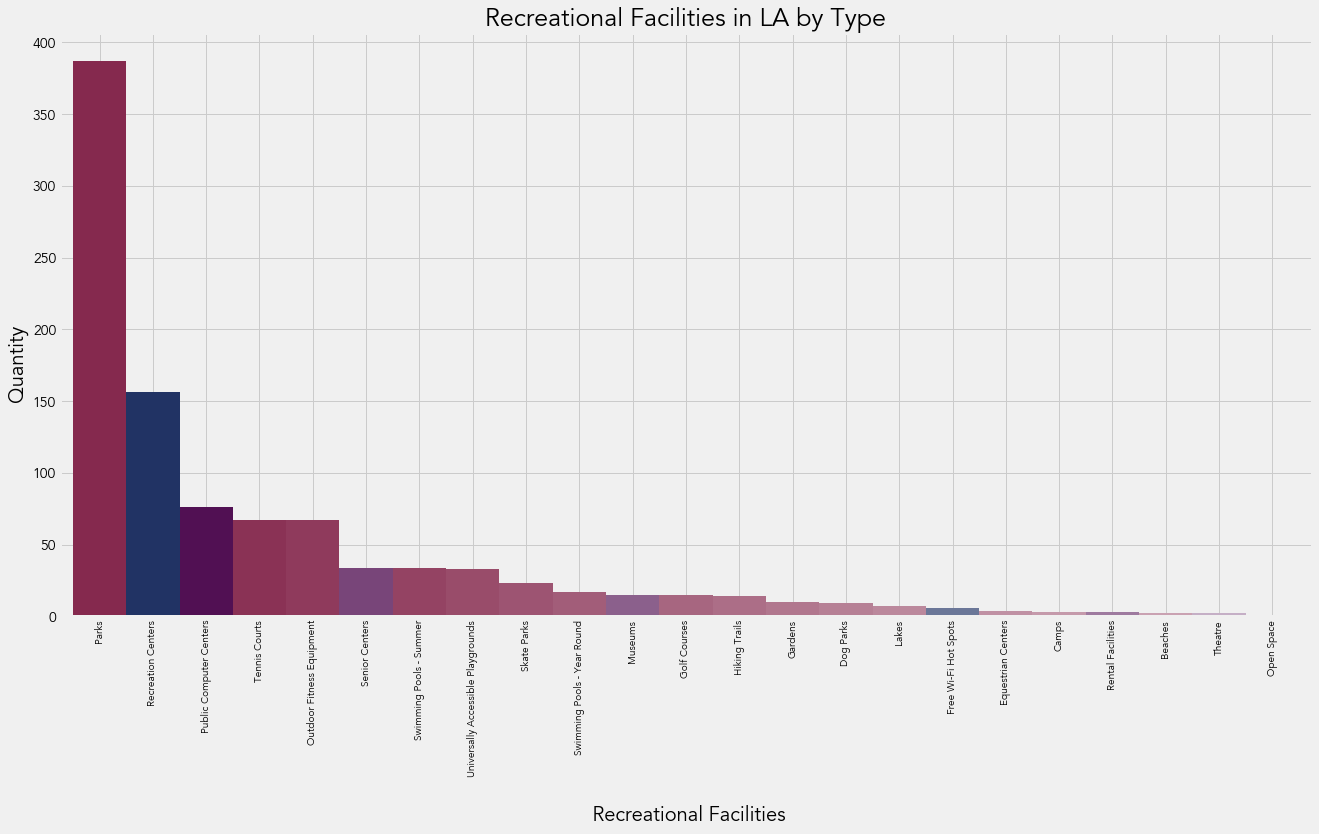

In [144]:
Location_types()

#### Alternative Representations

In [145]:
sum_column = dfcategory.sum(axis=0)
print (sum_column)
def treeplot():
    squarify.plot(sizes=sum_column,
                  color=['#85294e','#511053','#213364'],
                  label=['Outdoor Facilities', 'Indoor Facilities', 'Combined Facilities'],
                  text_kwargs={'fontsize':20, 'color':'white','weight':'bold'})
    plt.title('Proportions of Facility Category')
    plt.axis('off')
    plt.show()

Outdoor_Count     693.0
Indoor_Count      130.0
Combined_Count    162.0
dtype: float64


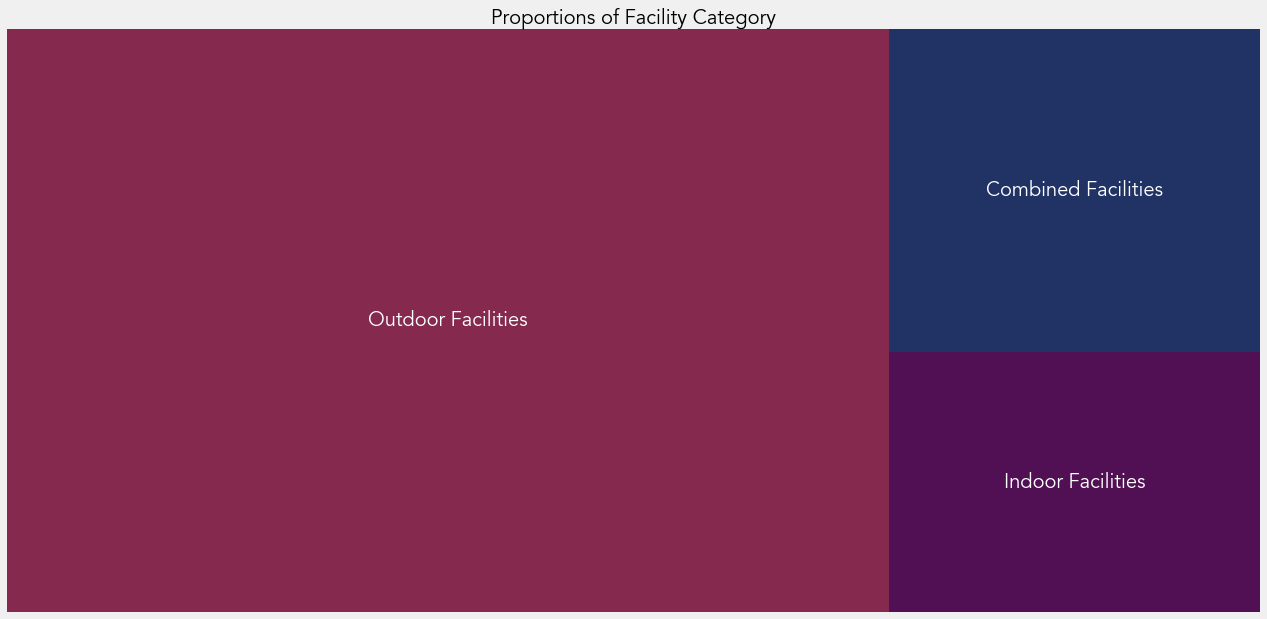

In [146]:
treeplot()

In [147]:
def treeplot2():
    dfrec_data["LocationType"].value_counts()

    squarify.plot(sizes=dfrec_data["LocationType"].value_counts(),
                  color=treeplotcolour,
                  label=labelsformat,
                  text_kwargs={'fontsize':12, 'color':'white','weight':'bold'}
                  ,pad=False)
    plt.title('Proportions of Facility Type')
    plt.axis('off')
    plt.show()

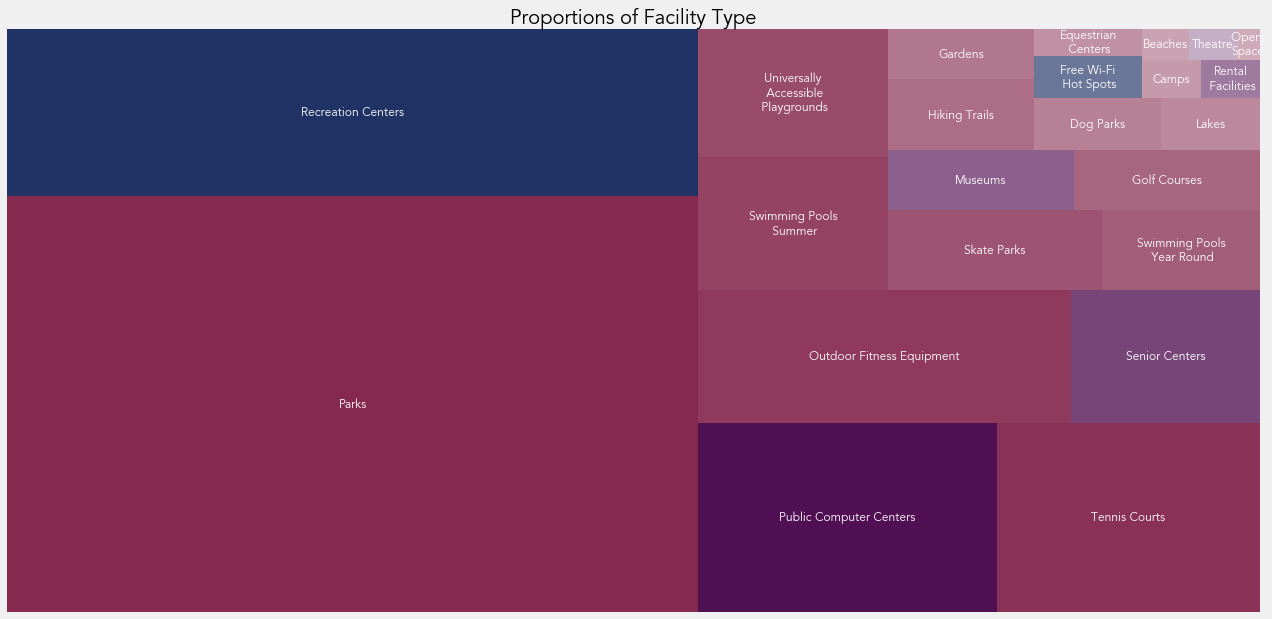

In [148]:
treeplot2()

In [149]:
def zipcodes_count():
    Zipcounts = dfrec_data["Zip"].value_counts()
    Zipcounts[Zipcounts < 5000].plot(kind="bar", color=['#96A5CB'], edgecolor='white')

    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Number of Recreational Facilities per Zip Code")
    plt.xlabel('\n Zip Codes', fontsize=20 )
    plt.ylabel('Number of Recreational Facilities', fontsize=20, rotation='vertical')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

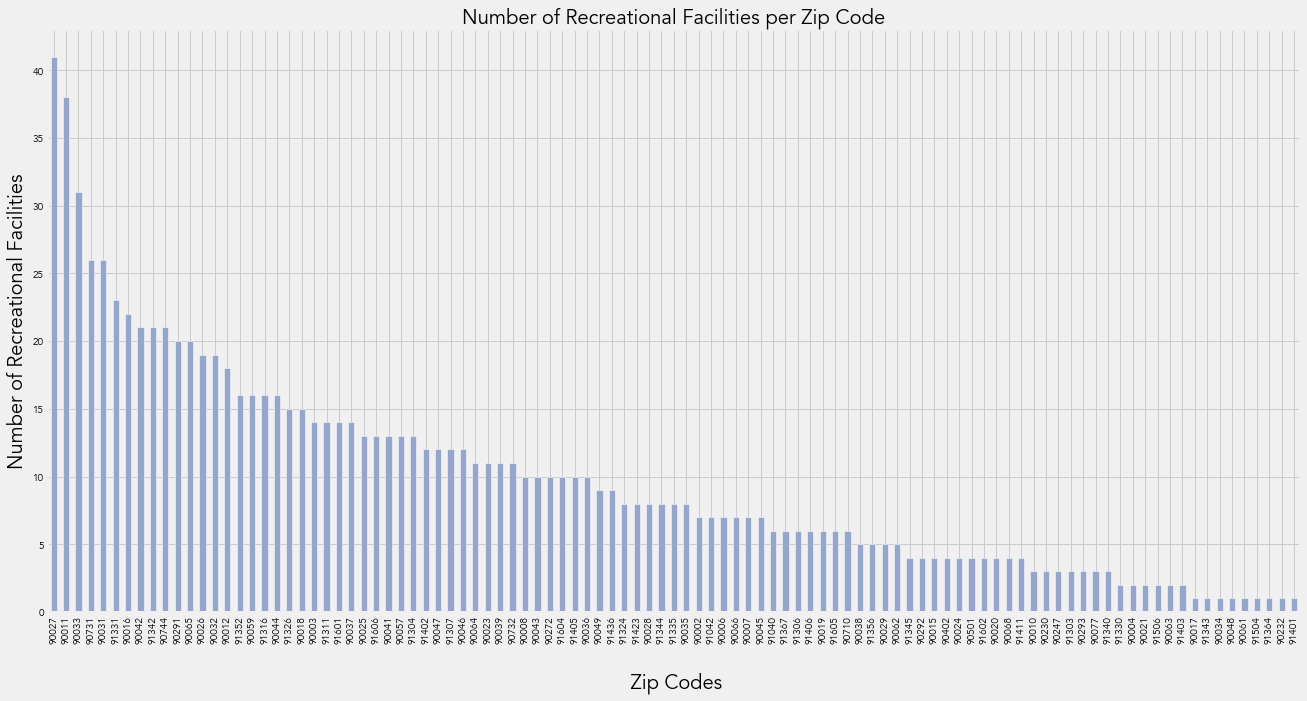

In [150]:
zipcodes_count()

In [151]:
#dfrec_data.head(1)
#dfrec_data["Zip"].value_counts()

In [152]:
def facilities_count():
    Zipcounts = dfrec_data["Zip"].value_counts()
    Zipcounts[Zipcounts < 5000].plot(kind="hist", bins=15, color=['#96A5CB'], edgecolor='white')

    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.title("Number of Recreational Facilities per Zip Code")
    plt.xlabel('\n Number of Recreational Facilities', fontsize=15)
    plt.ylabel('Number of Zip Codes', fontsize=15, rotation='vertical', ha='right')
    plt.grid(True)
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    return plt.show()

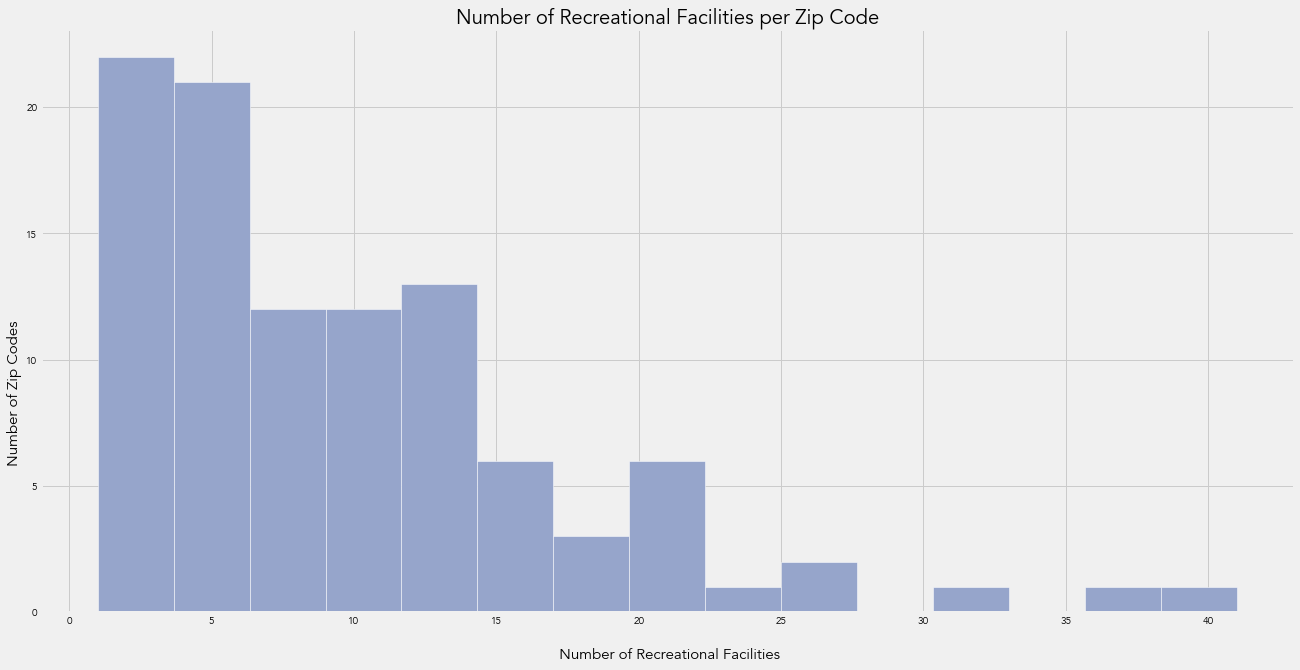

In [153]:
facilities_count()

In [430]:
types=dfmerged_data.columns.tolist()
def stacked():
    dfmerged_data.loc[:,['Parks','Tennis Courts','Outdoor Fitness Equipment','Swimming Pools - Summer',
         'Universally Accessible Playgrounds','Skate Parks','Swimming Pools - Year Round','Golf Courses',
         'Hiking Trails','Gardens','Dog Parks','Lakes','Equestrian Centers','Camps','Beaches','Open Space',
         'Public Computer Centers','Senior Centers','Museums','Rental Facilities','Theatre',
         'Recreation Centers','Free Wi-Fi Hot Spots']].plot.bar(stacked=True,color=stackedcolour).legend(bbox_to_anchor=(1, 1))

    
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Breakdown of Facility Type Per Zip Code", fontsize=20 )
    plt.xlabel('\n Zip Codes', fontsize=15 )
    plt.ylabel('Number of Recreational Facilities', fontsize=15, rotation='vertical', ha='right')
    plt.show()


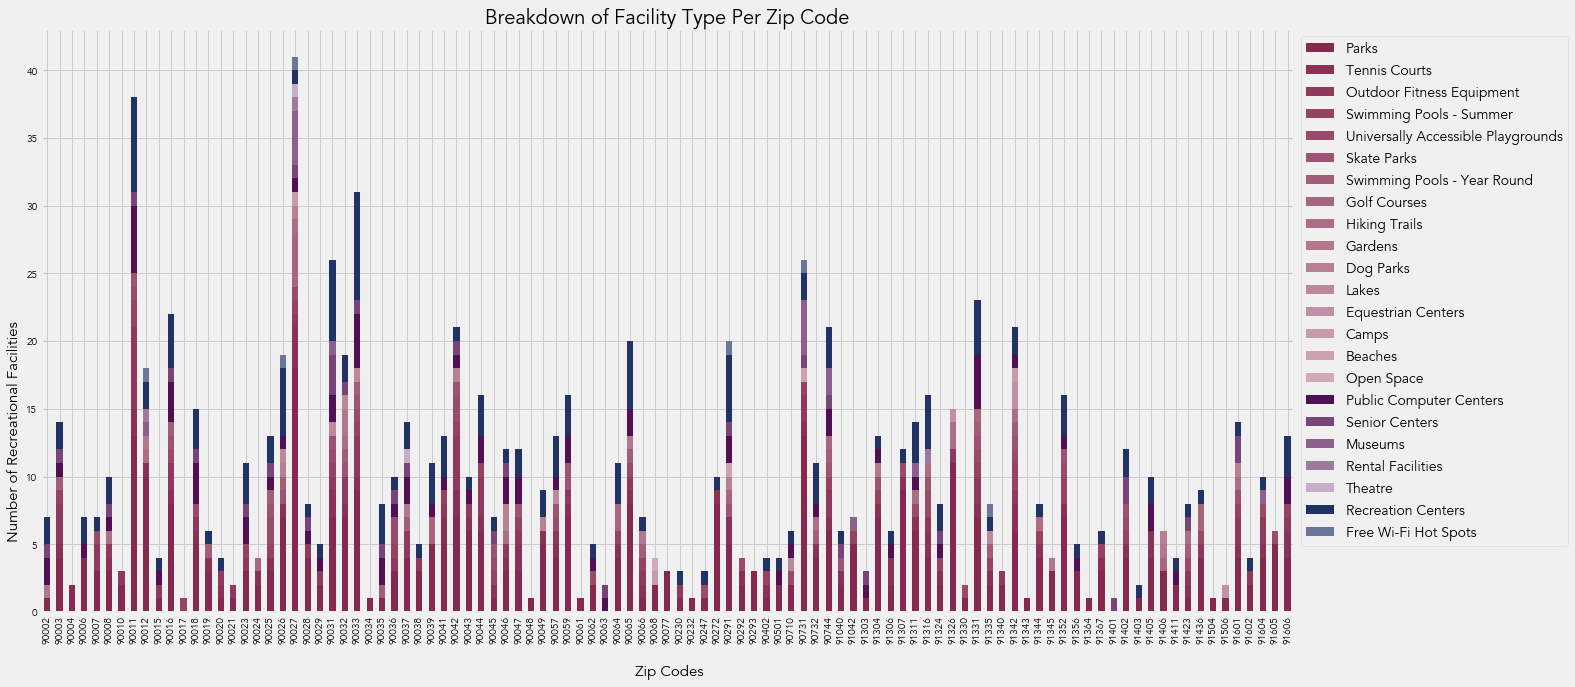

In [435]:
stacked()

In [401]:
def council_count():
    council = dfrec_data["CouncilDistrict"].value_counts()
    council[council < 5000].plot(kind="bar", color=['#96A5CB'], edgecolor='white')

    plt.yticks(fontsize=10,)
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Number of Recreational Facilities per Council District")
    plt.xlabel('\n Council Districts', fontsize=20)
    plt.ylabel('Number of Recreational Facilities', fontsize=20, rotation='vertical')
    plt.show()

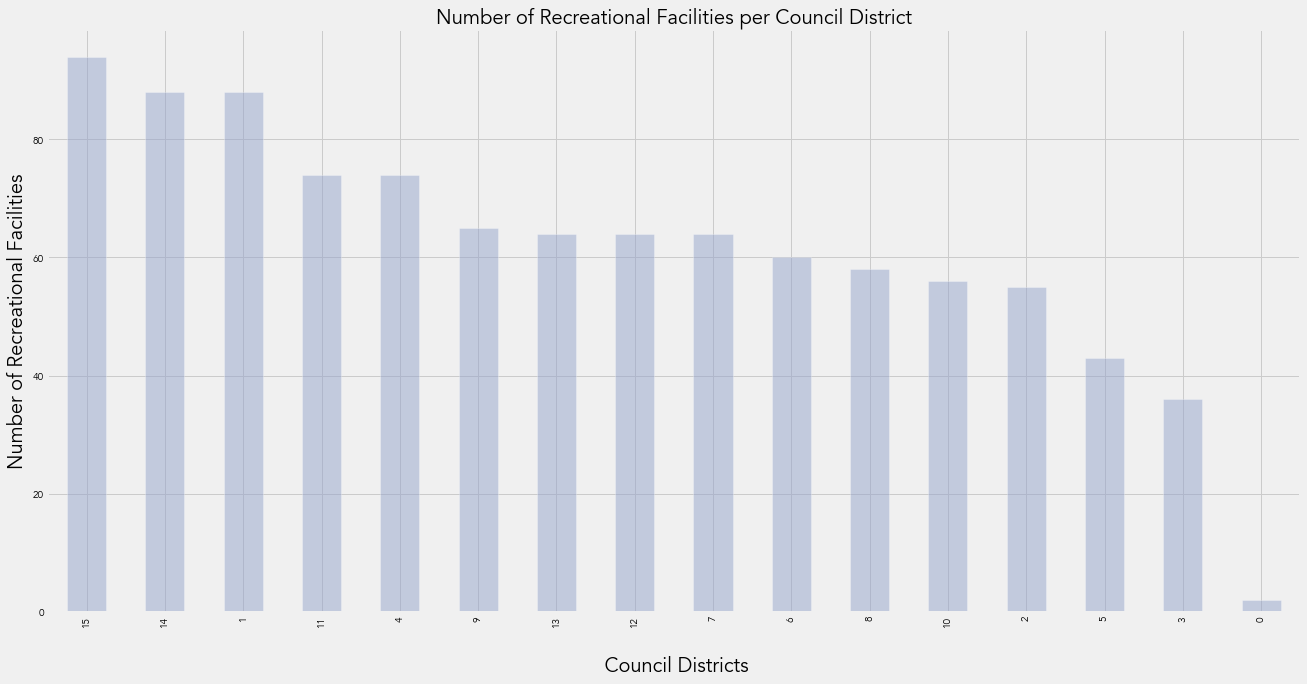

In [400]:
council_count()

In [402]:
def pop_correlation():
    df = pd.DataFrame({'Count': dfmerged_data["Total_Count"] , 'Pop':dfmerged_data["Population"], 'Zip':dfmerged_data.index})

    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()

    df.plot(x= 'Zip', y= 'Count',kind='bar', color='#AEBFD9', ax=ax1)
    df.plot(x = 'Zip', y='Pop',kind='line', marker='d', color='#8770AF', ax=ax2)
    
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel('Total Population', labelpad = 50 , fontsize=20)
    ax2.set_ylabel('Recreational Facilities Count', labelpad = 30, fontsize=20)
    ax1.set_xlabel('Zip Code',labelpad = 10, fontsize=20)
    plt.title("Correlation Between the Number of Recreational Facilities and Total Population Per Zip Code")
    ax1.get_legend().remove()
    bar = mpatches.Patch(color='#AEBFD9', label='Count')
    line = mpatches.Patch(color='#8770AF', label='Population')
    plt.legend(handles=[bar,line])
    return plt.show()


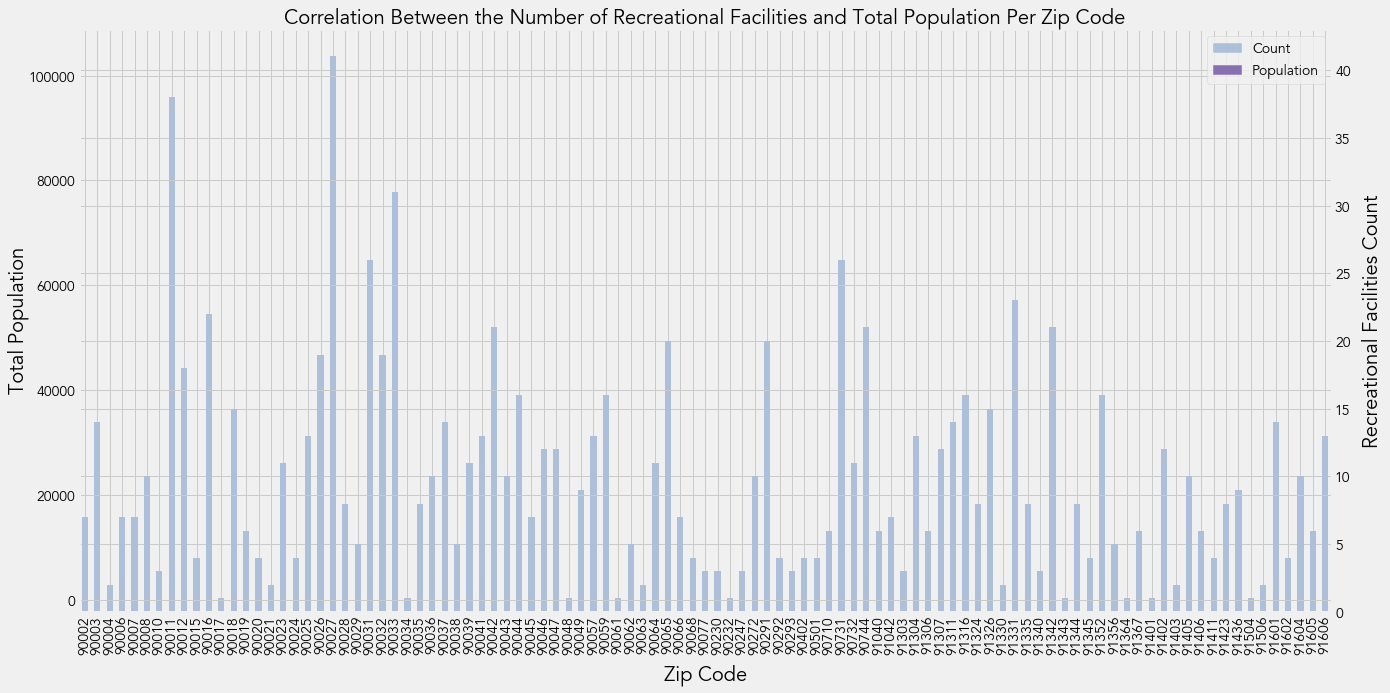

In [403]:
pop_correlation()

# Question: Are the types and number of recreational facilities within a zip code related to its demographic?
### Hypothesis: Yes

Demographic options available to investigate: total population, median age, total males, total females, total househoulds, average household size.

In [160]:
#scatter data frame shortcuts
dfscatter = pd.DataFrame({'Count': dfmerged_data["Total_Count"] , 'Age':dfmerged_data["MedianAge"], 'Zip':dfmerged_data.index ,'Pop':dfmerged_data["Population"],'House':dfmerged_data["Households"], 'Size':dfmerged_data["AvgHouseholdSize"]})

In [161]:
def pop_scatter():
    plt.scatter(x= dfscatter.Pop, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.title("Correlation Between Number of Recreational Facilities and Population Per Zip Code")
    plt.xlabel('Population', labelpad = 30 , fontsize=20)
    plt.ylabel('Recreational Facilities Count', labelpad = 20, fontsize=20)
    return plt.show()

def age_scatter():
    plt.scatter(x= dfscatter.Age, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.xlabel('Median Age', labelpad = 30, fontsize=20)
    plt.ylabel('Recreational Facilities Count', labelpad = 20,fontsize=20)
    plt.title("Correlation Between Number of Recreational Facilities and Median Age Per Zip Code")
    return plt.show()

def house_scatter():
    plt.scatter(x= dfscatter.House, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.title("Correlation Between Number of Recreational Facilities and Population Per Zip Code")
    plt.xlabel('Number of Households', labelpad = 30, fontsize=20)
    plt.ylabel('Recreational Facilities Count', labelpad = 20,fontsize=20)
    return plt.show()

def size_scatter():
    plt.scatter(x= dfscatter.Size, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.title("Correlation Between Number of Recreational Facilities and Average Household Size")
    plt.xlabel('Average Household Size', labelpad = 30, fontsize=20)
    plt.ylabel('Recreational Facilities Count', labelpad = 20,fontsize=20)
    return plt.show()

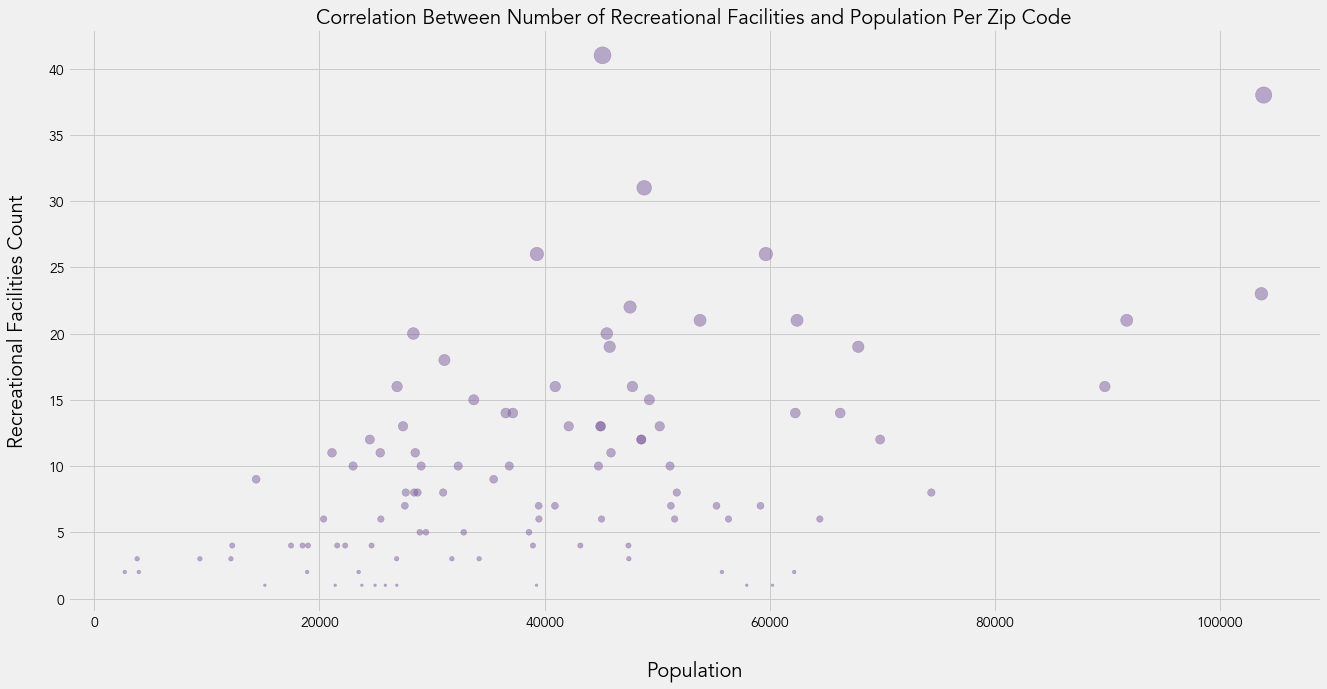

In [162]:
pop_scatter()

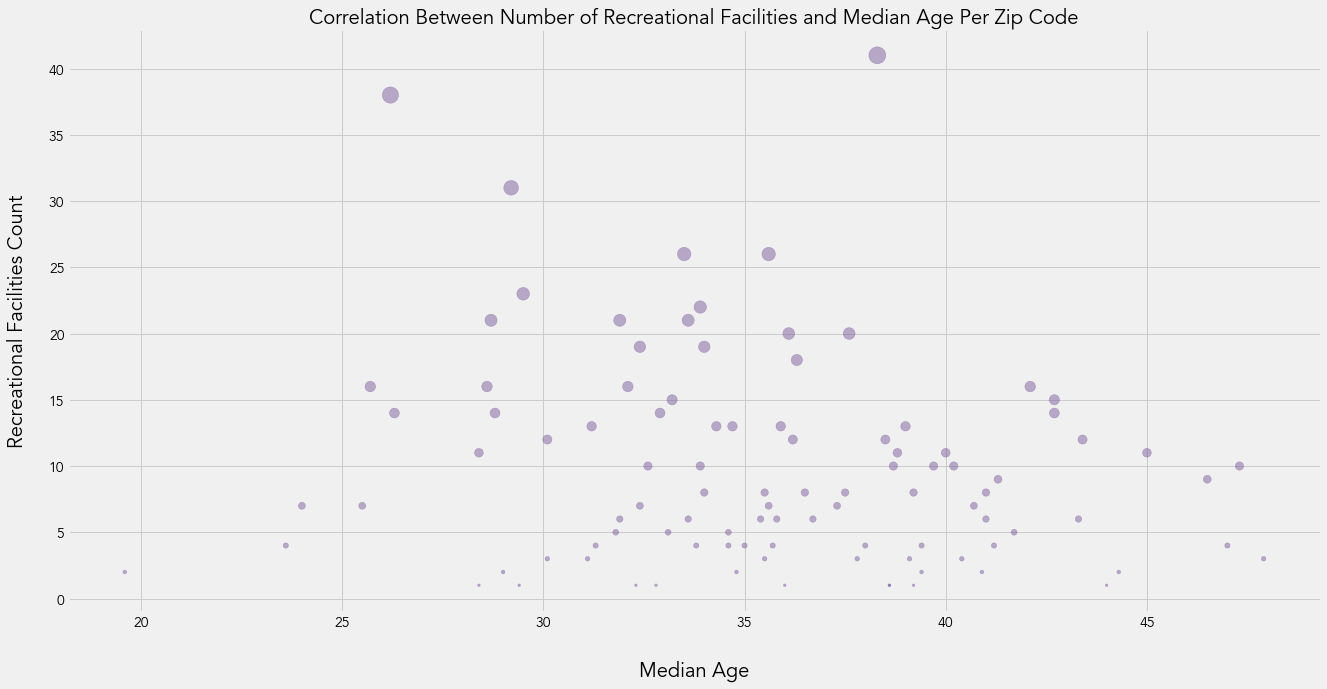

In [163]:
age_scatter()

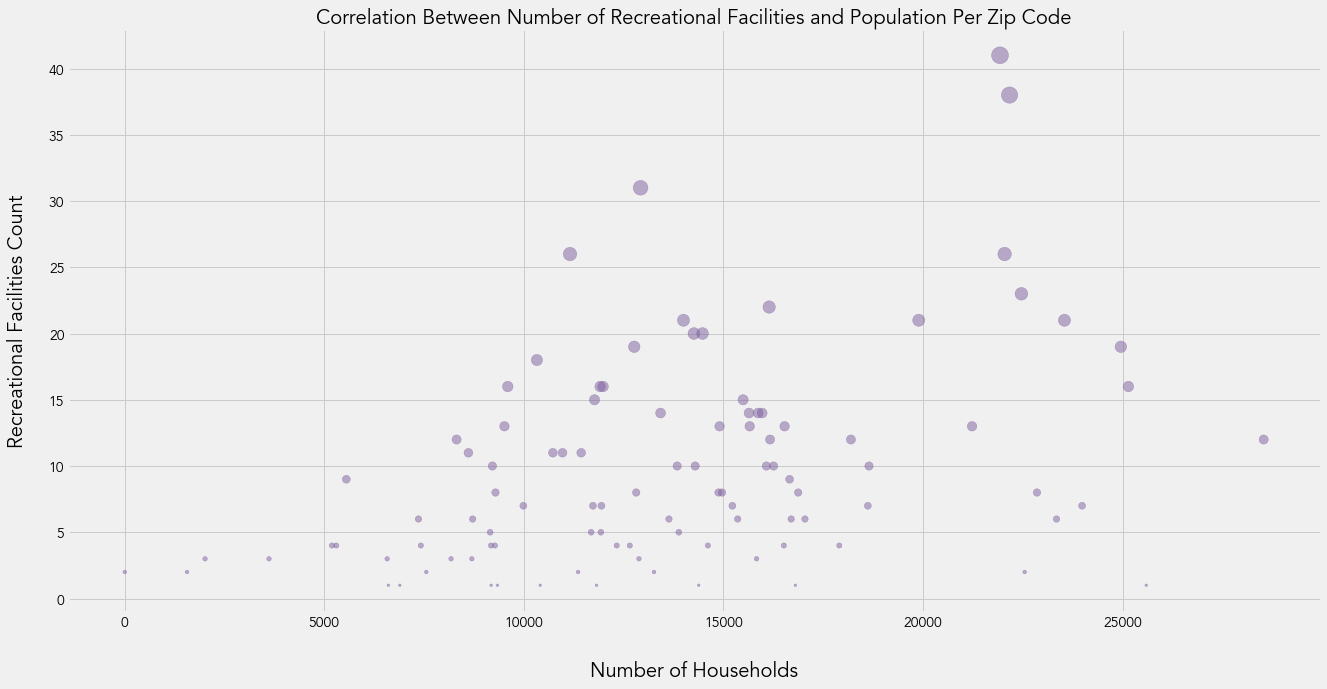

In [164]:
house_scatter()

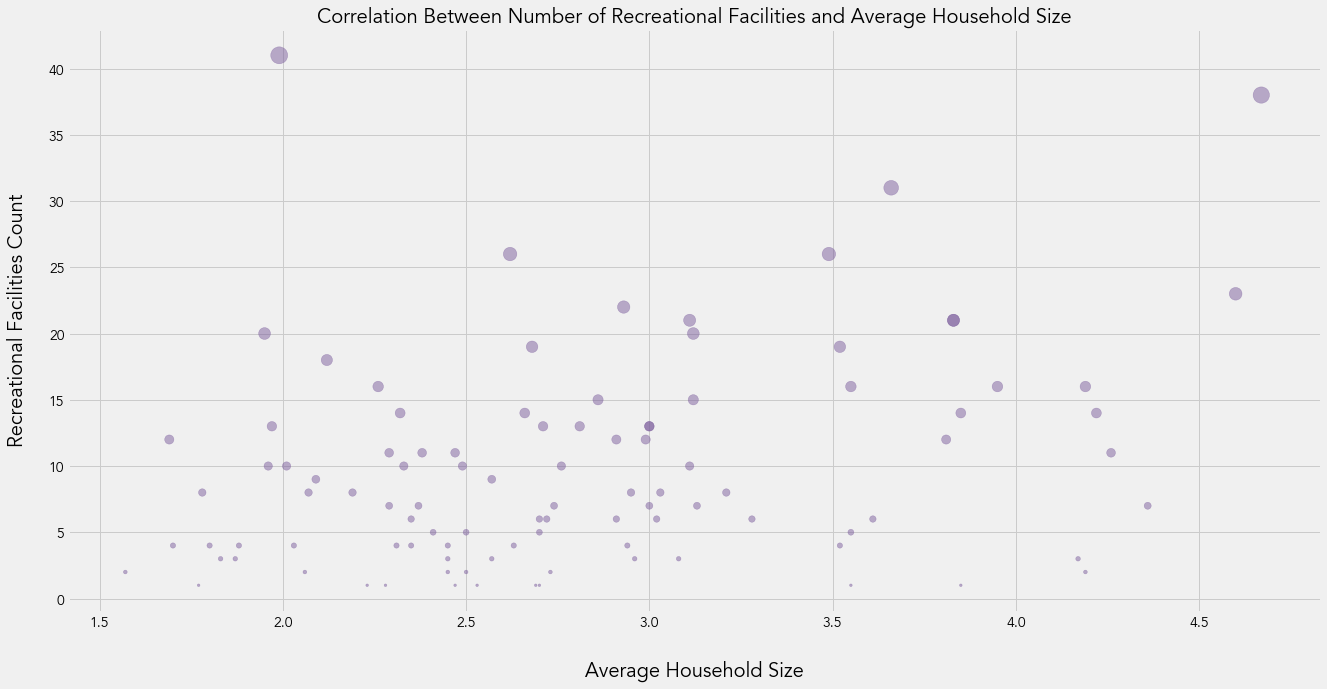

In [165]:
size_scatter()

In [166]:
def senior_scatter():
    plt.scatter(x= dfmerged_data["Households"], y= dfmerged_data["Universally Accessible Playgrounds"], color='y')
    plt.title("Correlation Between Number of Recreational Facilities and Population Per Zip Code")
    return plt.show()


In [167]:
#senior_scatter()
colours=['#511053','#56195B', '#5B2164', '#602A6C','#653374', '#6A3C7D', '#6E4485','#734D8E','#785696', '#7D5F9E','#7D5F9E', '#8770AF','#8875B2', '#8875B2', '#8A7AB4', '#8B7EB7', '#8C83B9', '#8E88BC','#8F8DBE', '#9192C1','#9297C3','#939BC6', '#95A0C8', '#96A5CB', '#96A5CB', '#9BAACE', '#A0B0D1', '#A5B5D4', '#A9BAD6', '#AEBFD9', '#B3C5DC', '#B8CADF']

In [183]:
def playground():
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Universally Accessible Playgrounds"], color='#511053', s=dfscatter.Count*7, alpha =0.5)
    plt.title("Correlation Between Number of Universally Accessible Playgrounds and Median Age")
    plt.xlabel('Median Age', labelpad = 30, fontsize=20)
    plt.ylabel('Universally Accessible Playgrounds Count', labelpad = 20,fontsize=20)
    plt.show()

def senior():    
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Senior Centers"],color='#511053', s=dfscatter.Count*7, alpha =0.55)
    plt.title("Correlation Between Number of Senior Centres and Median Age")
    plt.xlabel('Median Age', labelpad = 30, fontsize=20)
    plt.ylabel('Senior Centres Count', labelpad = 20,fontsize=20)
    plt.show()


def skate():
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Skate Parks"],color='#511053', s=dfscatter.Count*7, alpha =0.55)
    plt.title("Correlation Between Number of Skate Parks and Median Age")
    plt.xlabel('Median Age', labelpad = 30, fontsize=20)
    plt.ylabel('Skate Parks', labelpad = 20,fontsize=20)
    plt.show()

In [188]:
def rectotal():
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Recreation Centers"],color='#511053', s=dfscatter.Count*7, alpha =0.5)
    plt.title("Correlation Between Number of Recreational Centers and Median Age")
    plt.xlabel('Median Age', labelpad = 30, fontsize=20)
    plt.ylabel('Recreational Centers Count', labelpad = 20,fontsize=20)
    plt.show()

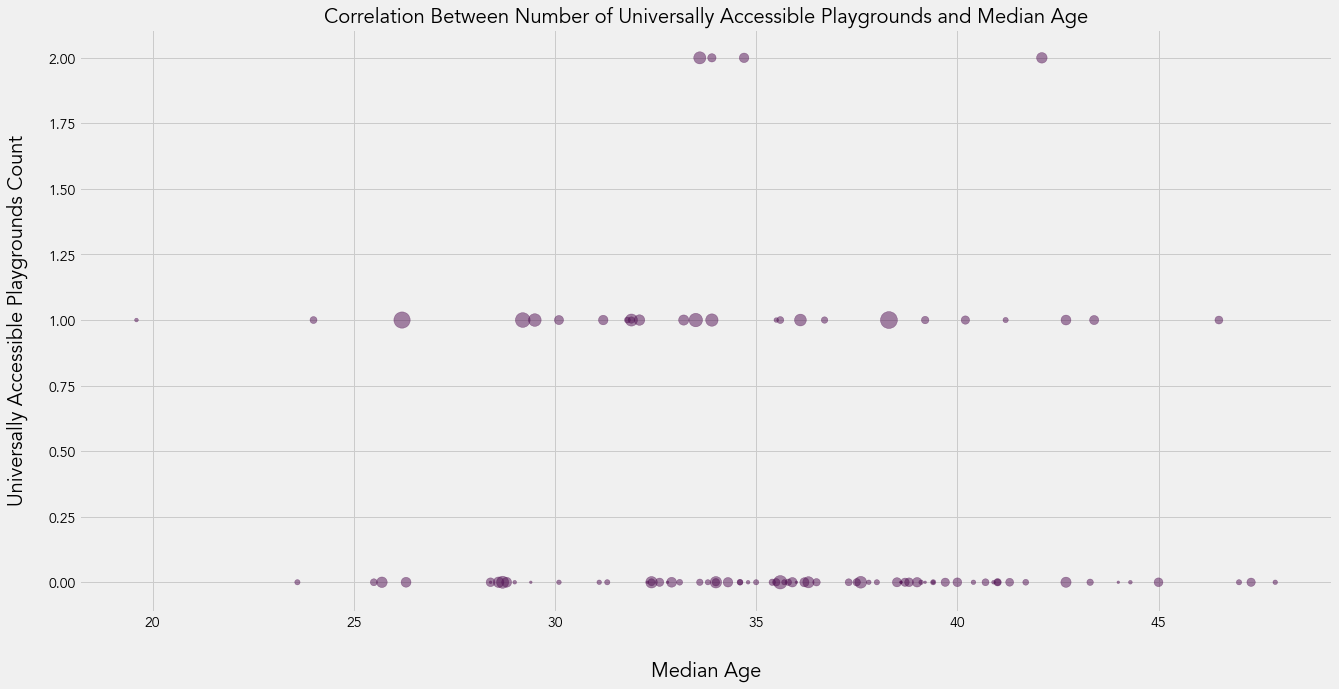

In [185]:
playground()

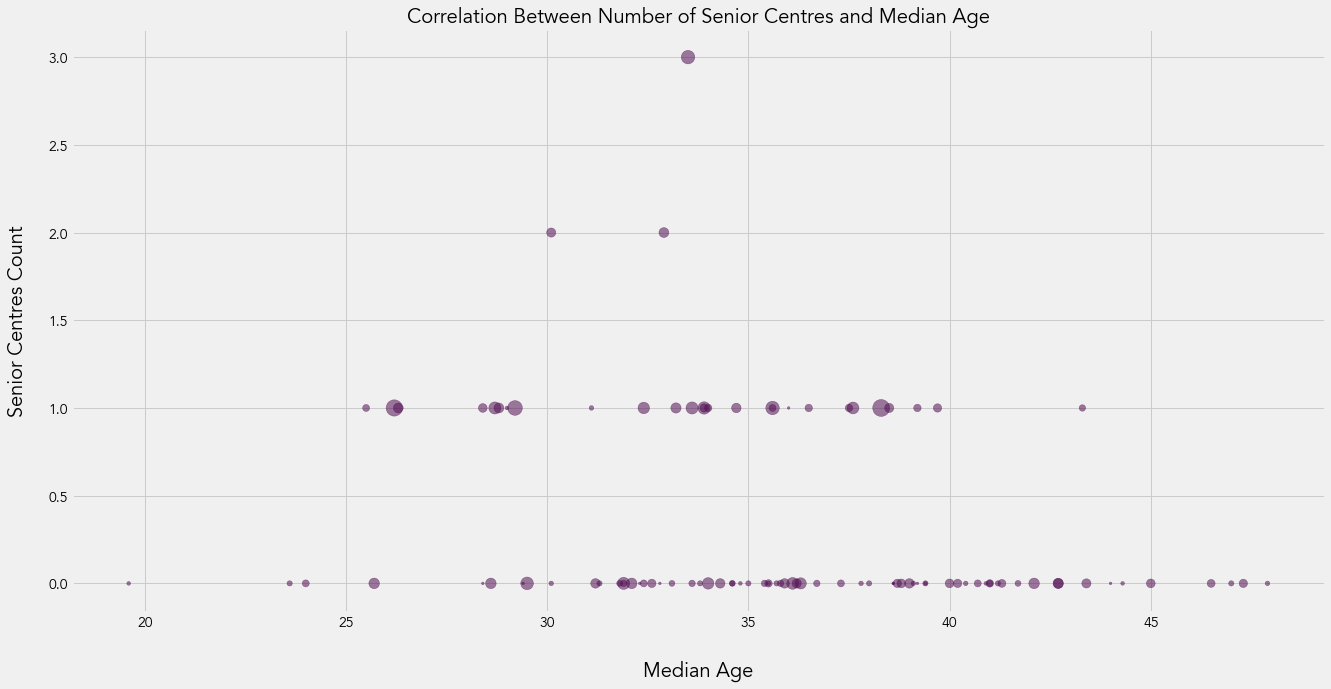

In [186]:
senior()

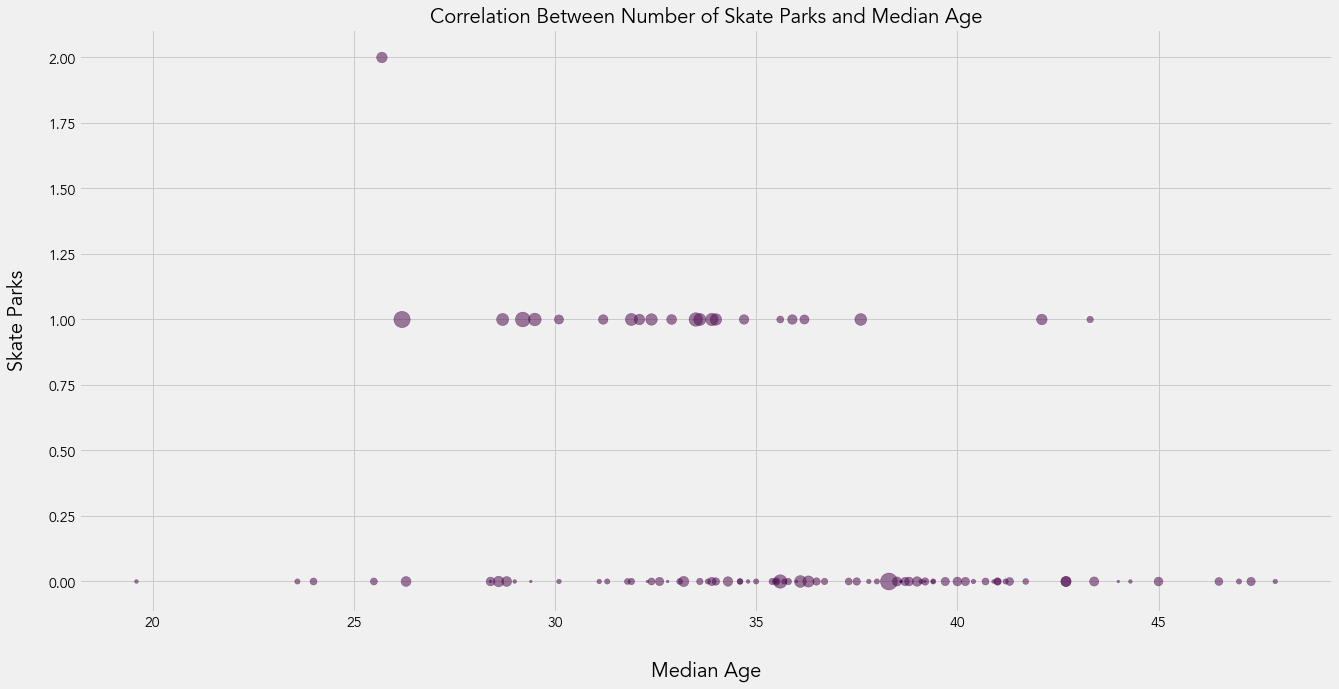

In [182]:
skate()

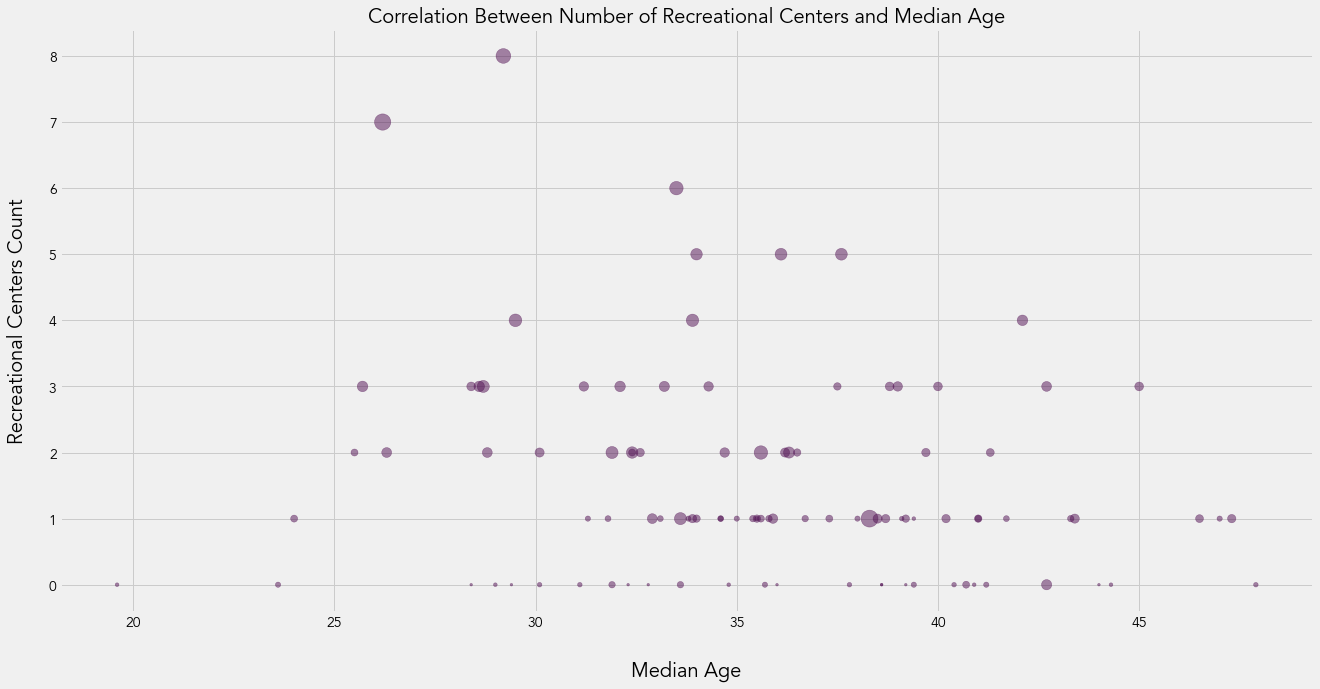

In [189]:
rectotal()

# Question: Are the types and number of recreational facilities within a zip code related to its demographic?
### Hypothesis: Yes
### Findings: No

# Maps

In [361]:
#MAPS AND PLOTS

#dfrec_data['geometry'] = dfrec_data.apply(lambda row: shapely.geometry.point.Point(row.GeoLat, row.GeoLong),axis = 1)


park_points = gp.GeoDataFrame(dfrec_data, geometry=gp.points_from_xy(dfrec_data.GeoLong, dfrec_data.GeoLat))
#park_points.plot()

county = gp.GeoDataFrame.from_file("LA_County_Boundaries-shp/LA_County_City_Boundaries.shp")
#county.head(2)
#county.plot90

city = gp.GeoDataFrame.from_file("LA_City_Boundaries-shp/LA_County_City_Boundaries.shp")
#print(city.head(1))
#city.plot()

zipgeo = gp.GeoDataFrame.from_file("Los_Angeles_City_Zip_Codes-shp/b982f3c3-ffe6-4e4a-b8e6-2bd1eb2c70642020328-1-26h3sc.00ox.shp")
#zipgeo.head(2)
#zip.plot()

#adding centroid
def add_centroid(row):
    return row.geometry.centroid

zipgeo["centroid"] = zipgeo.apply(add_centroid, axis=1)
zipgeo=zipgeo.rename(columns=({'ZIPCODE':'Zip'}))
zipgeo.set_index('ZIP',inplace=True)

#adding facility count
counts=dfrec_data["Zip"].value_counts()
reccounts = pd.DataFrame(counts)
reccounts=reccounts.rename(columns=({'Zip':'Total_Count'}))
#print(reccounts)
zipgeo.insert(5, "Facility Count",reccounts,True)


#add population
population=dfmerged_data["Population"]
pop = pd.DataFrame(population)
pop=pop.rename(columns=({'Zip':'Population'}))
#print(pop)
zipgeo.insert(5, "Population",pop,True)

#calculating area
zipgeo["area"] = zipgeo.area*10**4 

#Normalizing with area
zipgeo["Facility per km2"]= (zipgeo['Facility Count']/zipgeo['area'])

#Normalizing with population
zipgeo["Facility per 10,000 people"]= (zipgeo['Facility Count']/(zipgeo['Population']/10000))

#another method to calculate areainvolves the GeoSeries.to_crs() method, this was tested but when comparing the output
#to existing zip code land area details available online, it was inaccurate

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
zipgeo

/Users/kachaoui17/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



,OBJECTID,CITY,Zip,TOOLTIP,NLA_URL,Population,Facility Count,AnalysisAr,geometry,centroid,area,Facility per km2,"Facility per 10,000 people"
ZIP,,,,,,,,,,,,,
90001,1,IN,90001,Zip Code: 90001,n,NaN,NaN,0.928396,"POLYGON ((-118.25632 33.98869, -118.25632 33.9...",POINT (-118.2604636658164 33.97395575220297),2.345745,NaN,NaN
90002,2,IN,90002,Zip Code: 90002,n,51223.0,7.0,2.045266,"POLYGON ((-118.25591 33.96004, -118.25591 33.9...",POINT (-118.2484930498991 33.94670763893139),5.166076,1.354994,1.366574
90003,3,IN,90003,Zip Code: 90003,n,66266.0,14.0,3.681715,"POLYGON ((-118.26455 33.98808, -118.26455 33.9...",POINT (-118.2739475380618 33.96410568971133),9.301399,1.505150,2.112697
90004,4,IN,90004,Zip Code: 90004,n,62180.0,2.0,3.011609,"POLYGON ((-118.28410 34.08349, -118.28425 34.0...",POINT (-118.310950367423 34.07620838701735),7.618328,0.262525,0.321647
90005,5,IN,90005,Zip Code: 90005,n,NaN,NaN,1.323547,"MULTIPOLYGON (((-118.28423 34.06167, -118.2841...",POINT (-118.3100378660807 34.05979960766284),3.347479,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91606,153,IN,91606,Zip Code: 91606,n,44958.0,13.0,3.283931,"POLYGON ((-118.36386 34.19383, -118.36357 34.1...",POINT (-118.3886343713051 34.18644079217927),8.317850,1.562904,2.891588
91607,154,IN,91607,Zip Code: 91607,n,NaN,NaN,2.496958,"POLYGON ((-118.38838 34.17930, -118.38838 34.1...",POINT (-118.4002370699218 34.16625147652181),6.323045,NaN,NaN
91608,155,IN,91608,Zip Code: 91608,n,NaN,NaN,0.113004,"MULTIPOLYGON (((-118.34903 34.13159, -118.3487...",POINT (-118.3568891318951 34.13645190244275),0.286060,NaN,NaN


In [346]:
print("Area:", round(data.at[90003, "geometry"].area*10**4,90003), "square meters")

Area: 9.301399091886996 square meters


In [242]:
def Map_County():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    county.plot(ax=ax, color = "#939BC6",edgecolor='#7480c4',)
    city.plot(ax=ax, color = "#B8CADF",edgecolor='#a4bfde')
    park_points.plot(ax=ax, color='#8875B2', marker=".", markersize=5)
    plt.axis('off')

    plt.title("The City of LA Recreational Centre Locations in LA County", fontsize=25)
    return plt.show()
    
    #for idx, row in gdf.iterrows():

     #   plt.annotate(s=row["Location Name"], 
     #                xy=[row.geometry.x,row.geometry.y],
     #                horizontalalignment='center')
    #plt.title("Some pretty dodgy suburb names on a map");
    #plt.show()

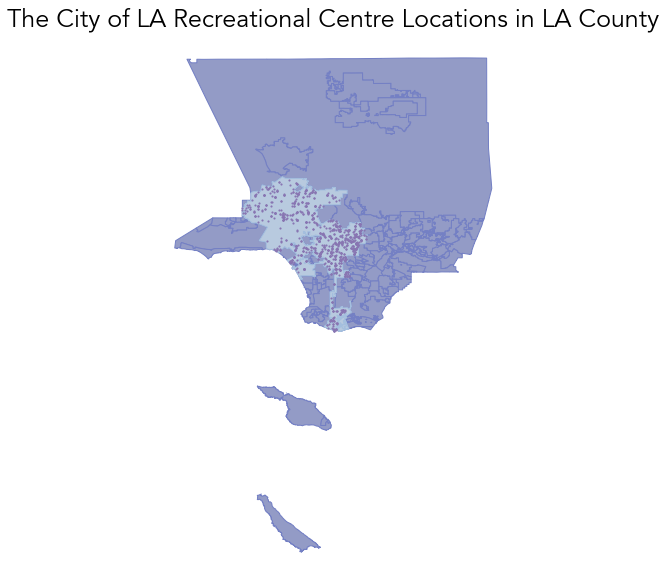

In [49]:
Map_County()

In [224]:
def Map_City():   
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    zipgeo.plot(ax=ax, color = "#B8CADF",edgecolor='white')
    park_points.plot(ax=ax, color='#8875B2', marker=".", markersize=10)
    plt.title("Recreational Centres in the City of LA", fontsize =25)
    plt.axis('off')
    
    for idx, row in zipgeo.iterrows():
        plt.annotate(s=row.Zip, 
                 xy=tuple(row.centroid.coords)[0],
                 xycoords="data",
                 horizontalalignment='center',
                    fontsize=10);
    return plt.show()

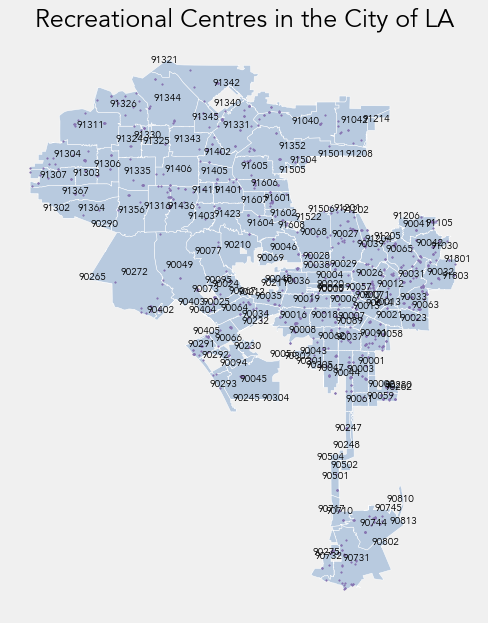

In [225]:
Map_City()

In [52]:
def choropleth():
    fig,ax=plt.subplots()
    ax.set_aspect('equal')

    zipgeo.plot(ax=ax, color = "lightgrey",edgecolor='white')
    zipgeo.plot(ax=ax, column="Facility Count", cmap='BuPu', legend=True,edgecolor='white')
    ax.set_title("Number of Recreational Facilities In LA Zip Code", fontsize=25)
    plt.axis('off')
    plt.show()

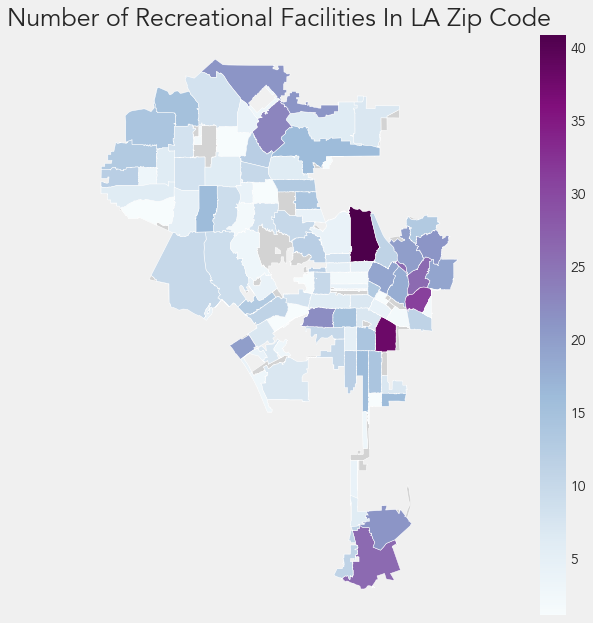

In [80]:
choropleth()

In [312]:
def choropleth2():
    fig,ax=plt.subplots()
    ax.set_aspect('equal')

    zipgeo.plot(ax=ax, color = "lightgrey",edgecolor='white')
    zipgeo.plot(ax=ax, column="area", cmap='BuPu', legend=True,edgecolor='white')
    ax.set_title("Choropleth Visualisation of Zip Code Land Area in LA ", fontsize=25)
    plt.axis('off')
    plt.show()

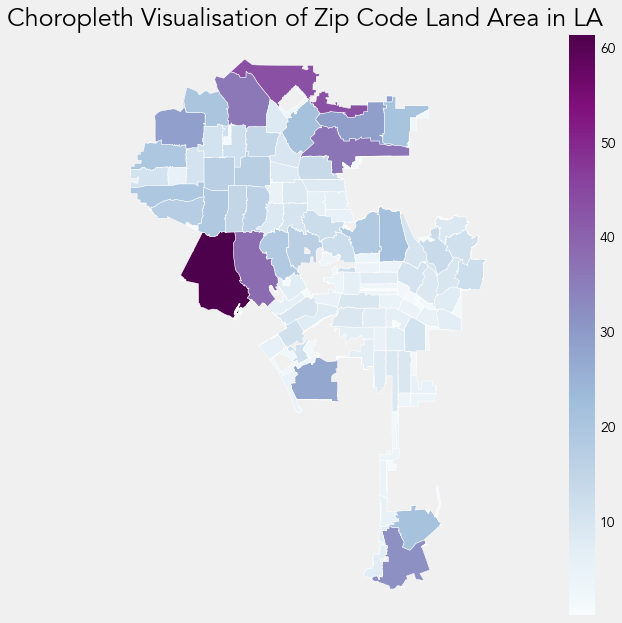

In [313]:
choropleth2()

In [314]:
def area():
    plt.scatter(x= zipgeo["area"], y= zipgeo["Facility Count"],color='#511053', s=dfscatter.Count*7, alpha =0.5)
    plt.title("Correlation Between Number of Recreational Centers and Zip Code Land Area")
    plt.xlabel('Area in km^2', labelpad = 30, fontsize=20)
    plt.ylabel('Recreational Facilities Count', labelpad = 20,fontsize=20)
    plt.show()

In [317]:
#area()

In [385]:
def zipcodes_countnorm():
    countsnorm = zipgeo["Facility per km2"]
    countsnorm[countsnorm < 40].plot(kind="bar", color=['#96A5CB'], edgecolor='white') 
    #removed 91506 as the shape file does not contain the full boundaries of the zip code leading to 8 facilities per km2 which is not accurate

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Number of Recreational Facilities per km^2 in each Zip Code")
    plt.xlabel('\n Zip Codes', fontsize=20 )
    plt.ylabel('Number of Recreational Facilities per km^2', fontsize=20, rotation='vertical')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

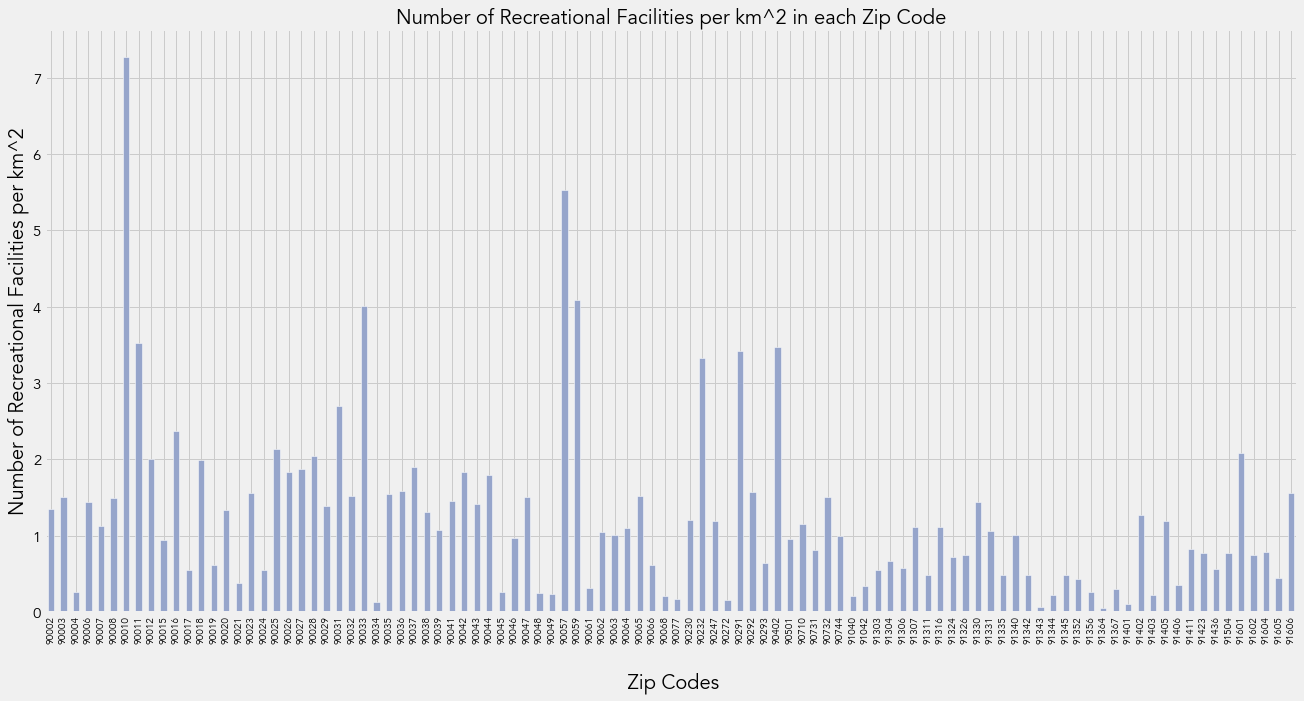

In [386]:
zipcodes_countnorm()

In [395]:
def zipcodes_countnorm_hist():
    countsnorm = zipgeo["Facility per km2"]
    countsnorm[countsnorm < 40].plot(kind="hist", bins=10, color=['#96A5CB'], edgecolor='white') 
    #removed 91506 as the shape file does not contain the full boundaries of the zip code leading to 8 facilities per km2 which is not accurate

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title("Number of Recreational Facilities per km^2 in each Zip Code")
    plt.xlabel('\n Number of Zip Codes', fontsize=20 )
    plt.ylabel('Number of Recreational Facilities per km^2', fontsize=20, rotation='vertical')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

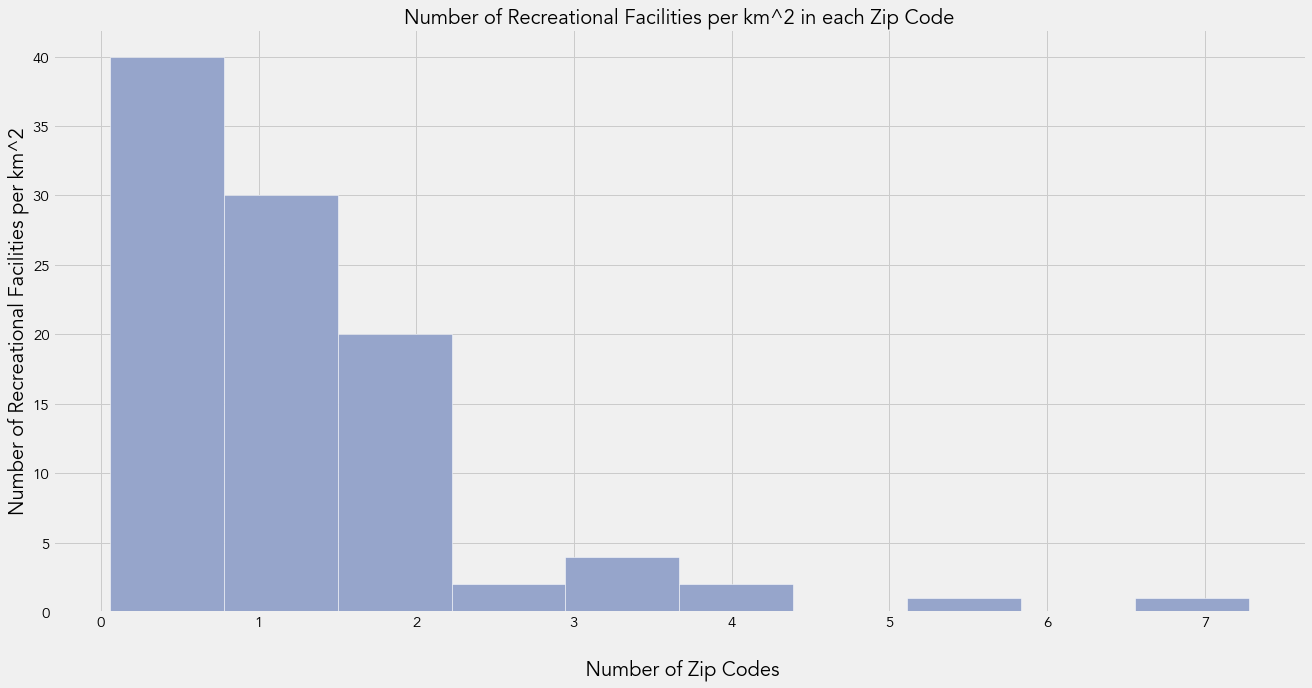

In [396]:
zipcodes_countnorm_hist()

In [379]:
def zipcodes_popnorm():
    countsnorm = zipgeo["Facility per 10,000 people"]
    countsnorm[countsnorm < 100].plot(kind="hist", color=['#96A5CB'], edgecolor='white') 
    #removed 91506 as the shape file does not contain the full boundaries of the zip code leading to 8 facilities per km2 which is not accurate

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title("Number of Recreational Facilities per 10,000 people in each Zip Code")
    plt.xlabel('\n Number of Zip Codes', fontsize=20 )
    plt.ylabel('Number of Recreational Facilities per 10,000 people', fontsize=20, rotation='vertical')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

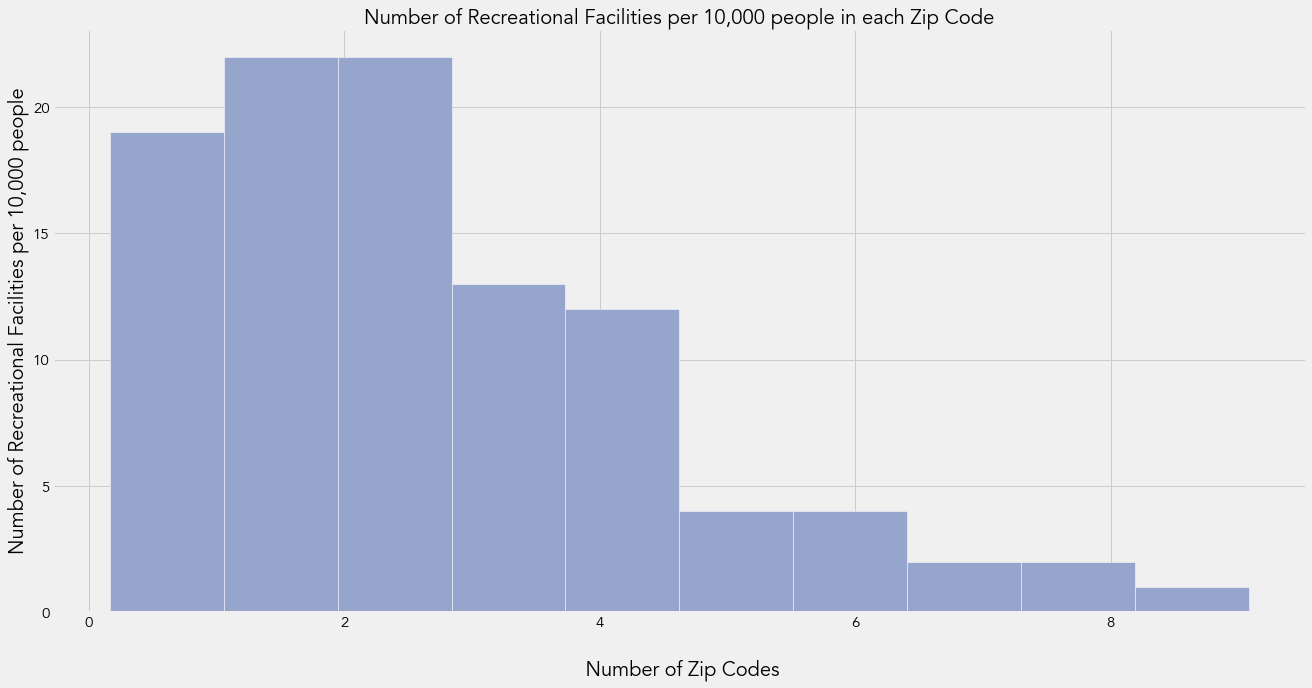

In [380]:
zipcodes_popnorm()

# Conclusion
* Around 2 facilities per 10,000 people and less than one per 1km^2 is the most common across LA zip codes
* Los Feliz (90027) is LA's recreational facility hub and the greenest area on a coloured map of LA
* Recreational facilities are not correlated to demographics
* The high proportion of parks over other types of facilities may be due to parks being multi-use spaces that could have multiple categories
* Demographics may be better correlated to schools, employment opportunities and neighbourhood safety rather than recreational ammenties

# Further Areas of Exploration
* Incorporate other forms of census data into this analysis including average income, crime rates and school zones.
* Topographic data could be combined in the mapping